<a href="https://colab.research.google.com/github/adeepH/Multimodal-Machine-Translation/blob/main/Notebooks/ResNet50_DistilBERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [20]:
import numpy as np
import pandas as pd
import torch 
from torch.utils.data import Dataset, DataLoader
import os
import h5py

In [21]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install transformers
!pip install timm

In [23]:
import os
import cv2
import gc
import numpy as np
import pandas as pd
import itertools
from tqdm.autonotebook import tqdm
import albumentations as A
import matplotlib.pyplot as plt

import torch
from torch import nn
import torch.nn.functional as F
import timm
from transformers import DistilBertModel, DistilBertConfig, DistilBertTokenizer

In [118]:
# Config files
class CFG:
    debug = False
    train_image_path = "/content/drive/MyDrive/Multimodal_Machine_Translation/Train"
    val_image_path = "/content/drive/MyDrive/Multimodal_Machine_Translation/Validation"
    test_image_path = "/content/drive/MyDrive/Multimodal_Machine_Translation/Test"
    captions_path = "."
    batch_size = 64
    num_workers = 2
    head_lr = 1e-3
    image_encoder_lr = 1e-4
    text_encoder_lr = 1e-5
    weight_decay = 1e-3
    patience = 1
    factor = 0.8
    epochs = 5
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model_name = 'resnet50'
    image_embedding = 2048
    text_encoder_model = "distilbert-base-uncased"
    text_embedding = 768
    text_tokenizer = "distilbert-base-uncased"
    max_length = 64

    pretrained = True # for both image encoder and text encoder
    trainable = True # for both image encoder and text encoder
    temperature = 1.0

    # image size
    size = 224

    #Path to save the model
    save_path = '/content/drive/MyDrive/Multimodal_Machine_Translation/Saved_Models'
    # for projection head; used for both image and text encoders
    num_projection_layers = 1
    projection_dim = 256 
    dropout = 0.1

In [25]:
class AvgMeter:
    def __init__(self, name="Metric"):
        self.name = name
        self.reset()

    def reset(self):
        self.avg, self.sum, self.count = [0] * 3

    def update(self, val, count=1):
        self.count += count
        self.sum += val * count
        self.avg = self.sum / self.count

    def __repr__(self):
        text = f"{self.name}: {self.avg:.4f}"
        return text

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group["lr"]

In [113]:
class CustomCLIP_Flickr30KDataset(torch.utils.data.Dataset):
    def __init__(self, image_filenames, captions, tokenizer, mode, transforms):
        """
        image_filenames and cpations must have the same length; so, if there are
        multiple captions for each image, the image_filenames must have repetitive
        file names 
        """

        self.image_filenames = image_filenames
        self.captions = list(captions)
        self.encoded_captions = tokenizer(
            list(captions), padding=True, truncation=True, max_length=CFG.max_length
        )
        self.transforms = transforms
        self.mode = mode

    def __getitem__(self, idx):
        item = {
            key: torch.tensor(values[idx])
            for key, values in self.encoded_captions.items()
        }

        if self.mode == "train":
            image = cv2.imread(f"{CFG.train_image_path}/{self.image_filenames[idx]}")

        elif self.mode == "validation":
            image = cv2.imread(f"{CFG.val_image_path}/{self.image_filenames[idx]}")
        
        elif self.mode == "test":
            image = cv2.imread(f"{CFG.test_images_path}/{self.image_filenames[idx]}")

        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = self.transforms(image=image)['image']
        item['image'] = torch.tensor(image).permute(2, 0, 1).float() 
        item['caption'] = self.captions[idx]

        return item


    def __len__(self):
        return len(self.captions)



def get_transforms(mode="train"):
    if mode == "train":
        return A.Compose(
            [
                A.Resize(CFG.size, CFG.size, always_apply=True),
                A.Normalize(max_pixel_value=255.0, always_apply=True),
            ]
        )
    else:
        return A.Compose(
            [
                A.Resize(CFG.size, CFG.size, always_apply=True),
                A.Normalize(max_pixel_value=255.0, always_apply=True),
            ]
        )

In [114]:
def build_loaders(dataframe, tokenizer, mode, shuffle=True):
    transforms = get_transforms(mode=mode)
    dataset = CustomCLIP_Flickr30KDataset(
        dataframe["image"].values,
        dataframe["caption"].to_numpy(),
        tokenizer=tokenizer,
        transforms=transforms,
        mode = mode
    )
    dataloader = torch.utils.data.DataLoader(
        dataset,
        batch_size=CFG.batch_size,
        num_workers=CFG.num_workers,
        shuffle=shuffle,
    )
    return dataloader

In [115]:
valid_loader = build_loaders(val, tokenizer, mode="validation")
valid_loss = valid_epoch(model, valid_loader)

In [65]:
TRAIN_CAPTIONS = '/content/drive/MyDrive/Multimodal MT/train.lc.norm.tok.en'
TRAIN_SPLIT = '/content/drive/MyDrive/Multimodal MT/image_splits/train_images.txt'
VAL_CAPTIONS = '/content/drive/MyDrive/Multimodal MT/val.lc.norm.tok.en'
VAL_SPLIT = '/content/drive/MyDrive/Multimodal_Machine_Translation/Image_Splits/image_splits/val_images.txt'

f = open(TRAIN_CAPTIONS,'r')
f = f.read().splitlines()
k = open(TRAIN_SPLIT, 'r')
k = k.read().splitlines()
a = open(VAL_SPLIT,'r')
a = a.read().splitlines()
b = open(VAL_CAPTIONS,'r')
b = b.read().splitlines()
train = pd.DataFrame()
val = pd.DataFrame()
val['image'] = a
val['caption'] = b
train['image'] = k
train['caption'] = f

In [61]:
def make_train_valid_dfs():
    dataframe = pd.read_csv(f"{CFG.captions_path}/captions.csv")
    max_id = dataframe["id"].max() + 1 if not CFG.debug else 100
    image_ids = np.arange(0, max_id)
    np.random.seed(42)
    valid_ids = np.random.choice(
        image_ids, size=int(0.2 * len(image_ids)), replace=False
    )
    train_ids = [id_ for id_ in image_ids if id_ not in valid_ids]
    train_dataframe = dataframe[dataframe["id"].isin(train_ids)].reset_index(drop=True)
    valid_dataframe = dataframe[dataframe["id"].isin(valid_ids)].reset_index(drop=True)
    return train_dataframe, valid_dataframe


def build_loaders(dataframe, tokenizer, mode, shuffle=True):
    transforms = get_transforms(mode=mode)
    dataset = CustomCLIP_Flickr30KDataset(
        dataframe["image"].values,
        dataframe["caption"].to_numpy(),
        tokenizer=tokenizer,
        transforms=transforms,
        mode = mode
    )
    dataloader = torch.utils.data.DataLoader(
        dataset,
        batch_size=CFG.batch_size,
        num_workers=CFG.num_workers,
        shuffle=shuffle,
    )
    return dataloader


In [117]:
valid_loader = build_loaders(val, tokenizer, mode="validation")
train_loader = build_loaders(train, tokenizer, mode='train')
valid_loss = valid_epoch(model, valid_loader)

In [30]:
class ImageEncoder(nn.Module):
    """
    Encode Images to a fixed sized vector
    """

    def __init__(self, model_name= CFG.model_name, pretrained=CFG.pretrained, trainable=CFG.trainable):
        super().__init__()
        self.model = timm.create_model(
            model_name, pretrained, num_classes=0, global_pool="avg",
        )
        for p in self.model.parameters():
            p.requires_grad = trainable
    
    def forward(self, x):
        return self.model(x)

In [31]:
class TextEncoder(nn.Module):
    """
    Encode texts to a fixed sized vectors
    """

    def __init__(self, model_name = CFG.text_encoder_model, pretrained=CFG.pretrained, trainable= CFG.trainable):
        super().__init__()
        if pretrained:
            self.model = DistilBertModel.from_pretrained(model_name)
        else:
            self.model = DistilBertModel(config=DistilBertConfig())
        
        for p in self.model.parameters():
            p.requires_grad = trainable
        
        # If one is using CLS token hidden representation as the sentence's embedding
        self.target_token_idx = 0
    
    def forward(self, input_ids, attention_mask):
        output = self.model(input_ids = input_ids, attention_mask = attention_mask)
        last_hidden_state = output.last_hidden_state
        return last_hidden_state[:, self.target_token_idx, :]

In [32]:
class ProjectionHead(nn.Module):

    def __init__(
        self,
        embedding_dim,
        projection_dim = CFG.projection_dim,
        dropout = CFG.dropout
    ):
        super().__init__()
        self.projection = nn.Linear(embedding_dim, projection_dim)
        self.gelu = nn.GELU()
        self.fc = nn.Linear(projection_dim, projection_dim)
        self.dropout = nn.Dropout(dropout)
        self.layer_norm = nn.LayerNorm(projection_dim)

    def forward(self, x):

        projection = self.projection(x)
        x = self.gelu(projection)
        x = self.fc(x)
        x = self.dropout(x)
        x = x + projection
        x = self.layer_norm(x)
        return x
    

In [33]:
class CLIPModel(nn.Module):

    def __init__(self,
                 temperature = CFG.temperature,
                 image_embedding = CFG.image_embedding,
                 text_embedding = CFG.text_embedding):
        super().__init__()
        self.image_encoder = ImageEncoder()
        self.text_encoder = TextEncoder()
        self.image_projection = ProjectionHead(embedding_dim=image_embedding)
        self.text_projection = ProjectionHead(embedding_dim=text_embedding)
        self.temperature = temperature
    
    def forward(self, batch):

        # Getting the image and text features
        image_features = self.image_encoder(batch['image'])
        text_features = self.text_encoder(
            input_ids = batch['input_ids'], attention_mask = batch['attention_mask']
        )

        # Getting Image and Text Embeddings with the same dimesnion
        image_embeddings = self.image_projection(image_features)
        text_embeddings = self.text_projection(text_features)

        # Calculating the losses
        logits = ( text_embeddings @ image_embeddings.T) / self.temperature
        images_similarity = image_embeddings @ image_embeddings.T
        texts_similarity = text_embeddings @ text_embeddings.T
        
        targets = F.softmax(
            (images_similarity + texts_similarity)/ 2 * self.temperature, dim = 1
        )
        texts_loss = cross_entropy(logits, targets, reduction='None')
        images_loss = cross_entropy(logits.T, targets.T, reduction='None')      
        loss = (images_loss + texts_loss) / 2.0 # Shape [BATCH SIZE]
        return loss.mean()
    
def cross_entropy(preds, targets, reduction=None):
    log_softmax = nn.LogSoftmax(dim=-1)
    loss = (-targets * log_softmax(preds)).sum(1)
    if reduction == 'None':
        return loss
    elif reduction == 'mean':
        return loss.mean()

In [35]:
def train_epoch(model, train_loader, optimizer, lr_scheduler, step):
    loss_meter = AvgMeter()
    tqdm_object = tqdm(train_loader, total=len(train_loader))
    for batch in tqdm_object:
        batch = {k: v.to(CFG.device) for k, v in batch.items() if k != "caption"}
        loss = model(batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if step == "batch":
            lr_scheduler.step()

        count = batch["image"].size(0)
        loss_meter.update(loss.item(), count)

        tqdm_object.set_postfix(train_loss=loss_meter.avg, lr=get_lr(optimizer))
    return loss_meter


def valid_epoch(model, valid_loader):
    loss_meter = AvgMeter()

    tqdm_object = tqdm(valid_loader, total=len(valid_loader))
    for batch in tqdm_object:
        batch = {k: v.to(CFG.device) for k, v in batch.items() if k != "caption"}
        loss = model(batch)

        count = batch["image"].size(0)
        loss_meter.update(loss.item(), count)

        tqdm_object.set_postfix(valid_loss=loss_meter.avg)
    return loss_meter



In [36]:
saved_models = '/content/drive/MyDrive/Multimodal_Machine_Translation/Saved_Models/'
import os
if not os.path.exists(saved_models):
    os.mkdir(saved_models)

saved_models +'best.pt'

'/content/drive/MyDrive/Multimodal_Machine_Translation/Saved_Models/best.pt'

In [43]:
tokenizer = DistilBertTokenizer.from_pretrained(CFG.text_tokenizer)
#train_loader = build_loaders(train, tokenizer, mode="train")
#valid_loader = build_loaders(val, tokenizer, mode="validation")


model = CLIPModel().to(CFG.device)
params = [
    {"params": model.image_encoder.parameters(), "lr": CFG.image_encoder_lr},
    {"params": model.text_encoder.parameters(), "lr": CFG.text_encoder_lr},
    {"params": itertools.chain(
        model.image_projection.parameters(), model.text_projection.parameters()
    ), "lr": CFG.head_lr, "weight_decay": CFG.weight_decay}
]
optimizer = torch.optim.AdamW(params, weight_decay=0.)
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode="min", patience=CFG.patience, factor=CFG.factor
)
step = "epoch"

best_loss = float('inf')
for epoch in range(CFG.epochs):
    print(f"Epoch: {epoch + 1}")
    model.train()
    train_loss = train_epoch(model, train_loader, optimizer, lr_scheduler, step) 
    model.eval()

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_projector.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch: 1



Epoch: 2



Epoch: 3



Epoch: 4



Epoch: 5


In [119]:
def main(): 
    tokenizer = DistilBertTokenizer.from_pretrained(CFG.text_tokenizer)
    train_loader = build_loaders(train, tokenizer, mode="train")
    valid_loader = build_loaders(val, tokenizer, mode="validation")


    model = CLIPModel().to(CFG.device)
    params = [
        {"params": model.image_encoder.parameters(), "lr": CFG.image_encoder_lr},
        {"params": model.text_encoder.parameters(), "lr": CFG.text_encoder_lr},
        {"params": itertools.chain(
            model.image_projection.parameters(), model.text_projection.parameters()
        ), "lr": CFG.head_lr, "weight_decay": CFG.weight_decay}
    ]
    optimizer = torch.optim.AdamW(params, weight_decay=0.)
    lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode="min", patience=CFG.patience, factor=CFG.factor
    )
    step = "epoch"

    best_loss = float('inf')
    for epoch in range(CFG.epochs):
        print(f"Epoch: {epoch + 1}")
        model.train()
        train_loss = train_epoch(model, train_loader, optimizer, lr_scheduler, step)
        model.eval()
        with torch.no_grad():
            valid_loss = valid_epoch(model, valid_loader)
        
        if valid_loss.avg < best_loss:
            best_loss = valid_loss.avg
            torch.save(model.state_dict(), f'{CFG.save_path}/resnet50_DistilBERT.pt')
            print("Saved Best Model!")
        
        lr_scheduler.step(valid_loss.avg)

In [120]:
main()

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_projector.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch: 1



Saved Best Model!
Epoch: 2



Saved Best Model!
Epoch: 3



Saved Best Model!
Epoch: 4



Epoch: 5


In [123]:
def get_image_embeddings(valid_df, model_path):
    tokenizer = DistilBertTokenizer.from_pretrained(CFG.text_tokenizer)
    valid_loader = build_loaders(valid_df, tokenizer, mode="validation")
    
    model = CLIPModel().to(CFG.device)
    model.load_state_dict(torch.load(model_path, map_location=CFG.device))
    model.eval()
    
    valid_image_embeddings = []
    with torch.no_grad():
        for batch in tqdm(valid_loader):
            image_features = model.image_encoder(batch["image"].to(CFG.device))
            image_embeddings = model.image_projection(image_features)
            valid_image_embeddings.append(image_embeddings)
    return model, torch.cat(valid_image_embeddings)

In [124]:
model, image_embeddings = get_image_embeddings(val, f'{CFG.save_path}/resnet50_DistilBERT.pt')

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_projector.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [137]:
def find_matches(model, image_embeddings, query, image_filenames, n=9):
    tokenizer = DistilBertTokenizer.from_pretrained(CFG.text_tokenizer)
    encoded_query = tokenizer([query])
    batch = {
        key: torch.tensor(values).to(CFG.device)
        for key, values in encoded_query.items()
    }
    with torch.no_grad():
        text_features = model.text_encoder(
            input_ids=batch["input_ids"], attention_mask=batch["attention_mask"]
        )
        text_embeddings = model.text_projection(text_features)
    
    image_embeddings_n = F.normalize(image_embeddings, p=2, dim=-1)
    text_embeddings_n = F.normalize(text_embeddings, p=2, dim=-1)
    dot_similarity = text_embeddings_n @ image_embeddings_n.T
    
    values, indices = torch.topk(dot_similarity.squeeze(0), n * 5)
    matches = [image_filenames[idx] for idx in indices[::5]]
    
    _, axes = plt.subplots(2, 2, figsize=(10, 10))
    for match, ax in zip(matches, axes.flatten()):
        image = cv2.imread(f"{CFG.val_image_path}/{match}")
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        ax.imshow(image)
        ax.axis("off")
    
    plt.show()

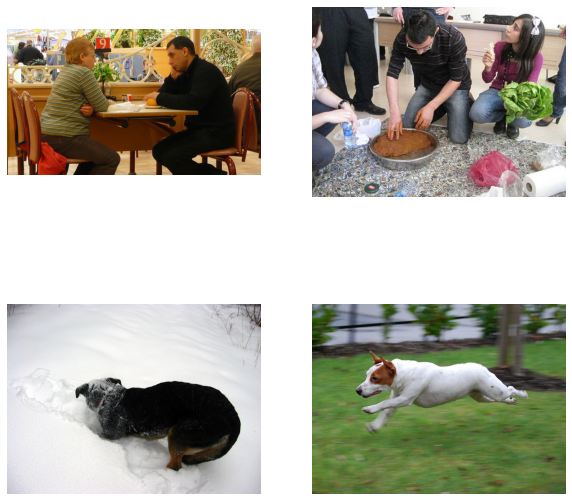

In [136]:
find_matches(model, 
             image_embeddings,
             query="this man is wearing a black cap or hat",
             image_filenames=val['image'].values,
             n=4)